* [Yelp, Not Kaggle Data Source](https://www.yelp.com/dataset/download)
* [Data Dictionary](https://www.yelp.com/dataset/documentation/main)

* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [ ] Extract from text key words that resulted in sentiment class (entity-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace
* [ ] compare competition side-by-side (Japanese restaurants)
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch bertopic --quiet 
!python -m spacy download en_core_web_md --quiet

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
# Data Processing
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Processing and Model Inference
from nltk.corpus import stopwords
import torch
import nltk
from transformers import pipeline, AutoTokenizer
## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-06-08 19:29:34.705600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 19:29:34.705730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 19:29:34.889755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/tmp/ipykernel_18/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [4]:
# dfr['categories'].value_counts()[:20]                                                                           

In [5]:
# Need to clean up category data

query = """
select business_id
, name
, address
, city
, state
, postal_code
, latitude
, longitude
, stars
, review_count
, attributes
, case when categories = 'Mexican, Restaurants' then 'Restaurants, Mexican'
when categories = 'Pizza, Restaurants' then 'Restaurants, Pizza'
when categories = 'Chinese, Restaurants' then 'Restaurants, Chinese'
when categories = 'Italian, Restaurants' then 'Restaurants, Italian'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'American (New), Restaurants' then 'Restaurants, American (New)'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'Vietnamese, Restaurants' then 'Restaurants, Vietnamese'
when categories = 'Cajun/Creole, Restaurants' then 'Restaurants, Cajun/Creole'
else categories
end as categories
, review_id
, user_id
, review_stars
, text
, date
from dfr
"""

dfr = duckdb.query(query).df()
dfr['categories'].value_counts()[:20]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [6]:
# dfr['categories'].value_counts()[:20]

In [7]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [8]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [9]:
# sample.head(1)

# Text Pre-Processing

In [10]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [11]:
# Get code to clean text: remove HTML tags
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
2147605,nwPYJ4nIndHyVlJ0aAR6mw,1.0,"Are you 23482!!??d kidding me? This place is disgusting. Boyfriend was hospitalized for FOOD POISONING for 2 days. Ruined our Easter weekend. \n\nHe had ordered a shredded beef super burrito Friday night and he still is recovering as of Sunday this morning. I didn't eat anything from here, just picked him up food for his lunch break while I was out running errands. \n\nI recommend eating here AT YOUR OWN RISK. Truly disappointed and will not return to this facility.","Are you 23482!!??d kidding me? This place is disgusting. Boyfriend was hospitalized for FOOD POISONING for 2 days. Ruined our Easter weekend. He had ordered a shredded beef super burrito Friday night and he still is recovering as of Sunday this morning. I didn't eat anything from here, just picked him up food for his lunch break while I was out running errands. I recommend eating here AT YOUR OWN RISK. Truly disappointed and will not return to this facility."
3690501,SSSYT7WQWqokSiDLOyfDVg,4.0,"Okay, we are somewhat still new to T-Town and the ways here. We are finding out the some of the same name places to eat don't serve the same food. This DQ is a classic example. We pulled in to get a burger and Blizzard but found out fast they don't serve burgers or anything that isn't frozen. We left still hungry but with blizzards in had. Thank God there was a Jack in the Box just down the street. The staff was nice and service fast, so they get 4 stars, 5 if they had a burger.","Okay, we are somewhat still new to T-Town and the ways here. We are finding out the some of the same name places to eat don't serve the same food. This DQ is a classic example. We pulled in to get a burger and Blizzard but found out fast they don't serve burgers or anything that isn't frozen. We left still hungry but with blizzards in had. Thank God there was a Jack in the Box just down the street. The staff was nice and service fast, so they get 4 stars, 5 if they had a burger."
2442635,x02sNkAurRLR4ZTnspXH2g,1.0,Where do I start . We sat at the bar where the bartender didn't know what beers were on tap . She didn't know the menu at all and had to read our copy . Food was served without napkins or silverware . No water was offered or served . Bartender had no clue how to work the point of sale or identify food when delivered . I feel staff had no training at all . When we spoke to the manager John he blamed everything on first week and new help. The truth is it comes down to lack of training and or no training prior to going to work . I don't think John cared enough to have a positive impact on the longevity of this establishment . We won't be back .,Where do I start . We sat at the bar where the bartender didn't know what beers were on tap . She didn't know the menu at all and had to read our copy . Food was served without napkins or silverware . No water was offered or served . Bartender had no clue how to work the point of sale or identify food when delivered . I feel staff had no training at all . When we spoke to the manager John he blamed everything on first week and new help. The truth is it comes down to lack of training and or no training prior to going to work . I don't think John cared enough to have a positive impact on the longevity of this establishment . We won't be back .
1079819,qrqaQ9ZI1eIbMQcQgs_BdA,5.0,Excellent food. Egg foo yun is top notch. We also got the crispy chicken extra spicy. Food is good for delivery too. Fast and hot. Had to give 5 stars. Sorry! Go eat!,Excellent food. Egg foo yun is top notch. We also got the crispy chicken extra spicy. Food is good for delivery too. Fast and hot. Had to give 5 stars. Sorry! Go eat!
2168945,HR6iDULPnMFKIVC93kanGg,1.0,"We usually come here every year \nBut this time omg Are you kidding me?? \nwe Came here on 08/07/21 and \nI don't know what happens to this place \nNew owner or what !?? \nThe foods was not good AT ALL \nWe ordered oysters shooters,sashimi 

In [12]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [13]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5min 53s, sys: 77.1 ms, total: 5min 53s
Wall time: 5min 57s


,review_id,review_stars,text,clean_text,num_tokens_tok
2147605,nwPYJ4nIndHyVlJ0aAR6mw,1.0,"Are you 23482!!??d kidding me? This place is disgusting. Boyfriend was hospitalized for FOOD POISONING for 2 days. Ruined our Easter weekend. \n\nHe had ordered a shredded beef super burrito Friday night and he still is recovering as of Sunday this morning. I didn't eat anything from here, just picked him up food for his lunch break while I was out running errands. \n\nI recommend eating here AT YOUR OWN RISK. Truly disappointed and will not return to this facility.","are you 23482!!??d kidding me? this place is disgusting. boyfriend was hospitalized for food poisoning for 2 days. ruined our easter weekend. he had ordered a shredded beef super burrito friday night and he still is recovering as of sunday this morning. i didn't eat anything from here, just picked him up food for his lunch break while i was out running errands. i recommend eating here at your own risk. truly disappointed and will not return to this facility.",101
3690501,SSSYT7WQWqokSiDLOyfDVg,4.0,"Okay, we are somewhat still new to T-Town and the ways here. We are finding out the some of the same name places to eat don't serve the same food. This DQ is a classic example. We pulled in to get a burger and Blizzard but found out fast they don't serve burgers or anything that isn't frozen. We left still hungry but with blizzards in had. Thank God there was a Jack in the Box just down the street. The staff was nice and service fast, so they get 4 stars, 5 if they had a burger.","okay, we are somewhat still new to t-town and the ways here. we are finding out the some of the same name places to eat don't serve the same food. this dq is a classic example. we pulled in to get a burger and blizzard but found out fast they don't serve burgers or anything that isn't frozen. we left still hungry but with blizzards in had. thank god there was a jack in the box just down the street. the staff was nice and service fast, so they get 4 stars, 5 if they had a burger.",118
2442635,x02sNkAurRLR4ZTnspXH2g,1.0,Where do I start . We sat at the bar where the bartender didn't know what beers were on tap . She didn't know the menu at all and had to read our copy . Food was served without napkins or silverware . No water was offered or served . Bartender had no clue how to work the point of sale or identify food when delivered . I feel staff had no training at all . When we spoke to the manager John he blamed everything on first week and new help. The truth is it comes down to lack of training and or no training prior to going to work . I don't think John cared enough to have a positive impact on the longevity of this establishment . We won't be back .,where do i start . we sat at the bar where the bartender didn't know what beers were on tap . she didn't know the menu at all and had to read our copy . food was served without napkins or silverware . no water was offered or served . bartender had no clue how to work the point of sale or identify food when delivered . i feel staff had no training at all . when we spoke to the manager john he blamed everything on first week and new help. the truth is it comes down to lack of training and or no training prior to going to work . i don't think john cared enough to have a positive impact on the longevity of this establishment . we won't be back .,146
1079819,qrqaQ9ZI1eIbMQcQgs_BdA,5.0,Excellent food. Egg foo yun is top notch. We also got the crispy chicken extra spicy. Food is good for delivery too. Fast and hot. Had to give 5 stars. Sorry! Go eat!,excellent food. egg foo yun is top notch. we also got the crispy chicken extra spicy. food is good for delivery too. fast and hot. had to give 5 stars. sorry! go eat!,42
2168945,HR6iDULPnMFKIVC93kanGg,1.0,"We usually come here every year \nBut this time omg Are you kidding me?? \nwe Came here on 08/07/21 and \nI don't know what happens to this place \nNew owner or what !?? \nThe foods was not good AT ALL \nWe ord

In [14]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,nwPYJ4nIndHyVlJ0aAR6mw,1.0,"Are you 23482!!??d kidding me? This place is disgusting. Boyfriend was hospitalized for FOOD POISONING for 2 days. Ruined our Easter weekend. \n\nHe had ordered a shredded beef super burrito Friday night and he still is recovering as of Sunday this morning. I didn't eat anything from here, just picked him up food for his lunch break while I was out running errands. \n\nI recommend eating here AT YOUR OWN RISK. Truly disappointed and will not return to this facility.","are you 23482!!??d kidding me? this place is disgusting. boyfriend was hospitalized for food poisoning for 2 days. ruined our easter weekend. he had ordered a shredded beef super burrito friday night and he still is recovering as of sunday this morning. i didn't eat anything from here, just picked him up food for his lunch break while i was out running errands. i recommend eating here at your own risk. truly disappointed and will not return to this facility.",101
1,SSSYT7WQWqokSiDLOyfDVg,4.0,"Okay, we are somewhat still new to T-Town and the ways here. We are finding out the some of the same name places to eat don't serve the same food. This DQ is a classic example. We pulled in to get a burger and Blizzard but found out fast they don't serve burgers or anything that isn't frozen. We left still hungry but with blizzards in had. Thank God there was a Jack in the Box just down the street. The staff was nice and service fast, so they get 4 stars, 5 if they had a burger.","okay, we are somewhat still new to t-town and the ways here. we are finding out the some of the same name places to eat don't serve the same food. this dq is a classic example. we pulled in to get a burger and blizzard but found out fast they don't serve burgers or anything that isn't frozen. we left still hungry but with blizzards in had. thank god there was a jack in the box just down the street. the staff was nice and service fast, so they get 4 stars, 5 if they had a burger.",118
2,x02sNkAurRLR4ZTnspXH2g,1.0,Where do I start . We sat at the bar where the bartender didn't know what beers were on tap . She didn't know the menu at all and had to read our copy . Food was served without napkins or silverware . No water was offered or served . Bartender had no clue how to work the point of sale or identify food when delivered . I feel staff had no training at all . When we spoke to the manager John he blamed everything on first week and new help. The truth is it comes down to lack of training and or no training prior to going to work . I don't think John cared enough to have a positive impact on the longevity of this establishment . We won't be back .,where do i start . we sat at the bar where the bartender didn't know what beers were on tap . she didn't know the menu at all and had to read our copy . food was served without napkins or silverware . no water was offered or served . bartender had no clue how to work the point of sale or identify food when delivered . i feel staff had no training at all . when we spoke to the manager john he blamed everything on first week and new help. the truth is it comes down to lack of training and or no training prior to going to work . i don't think john cared enough to have a positive impact on the longevity of this establishment . we won't be back .,146
3,qrqaQ9ZI1eIbMQcQgs_BdA,5.0,Excellent food. Egg foo yun is top notch. We also got the crispy chicken extra spicy. Food is good for delivery too. Fast and hot. Had to give 5 stars. Sorry! Go eat!,excellent food. egg foo yun is top notch. we also got the crispy chicken extra spicy. food is good for delivery too. fast and hot. had to give 5 stars. sorry! go eat!,42
4,HR6iDULPnMFKIVC93kanGg,1.0,"We usually come here every year \nBut this time omg Are you kidding me?? \nwe Came here on 08/07/21 and \nI don't know what happens to this place \nNew owner or what !?? \nThe foods was not good AT ALL \nWe ordered oysters shooters,sashimi 

In [15]:
#Check max number tokens
# query = """
# select max(num_tokens_tok) as max_tokens
# from sample_short_rev
# """

# duckdb.query(query).df()

In [16]:
# remaining of sample after token length filter
# len(sample_short_rev)

# Sentiment Classification

In [17]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [18]:
test = sample_short_rev.sample(n=5000)

In [19]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 18min 38s, sys: 2.25 s, total: 18min 40s
Wall time: 9min 22s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
351007,cvTuS1N0O76LtBbz4eWcAg,1.0,"This was the worse Reastraunt I have ever been to, my son's 19th birthday was today 7-31 and he asked me to meet him here for dinner. I arrived 10 minutes early gave my name to the Host to wait for a table. I asked the Host when we were seated to tell the server it was my son's birthday. The food was terrible and took forever to arrive at the table. The host never mentioned to the server my son's birthday. While leaving I spoke to manager he said he was sorry that happened. I will never vist this store again.","this was the worse reastraunt i have ever been to, my son's 19th birthday was today 7-31 and he asked me to meet him here for dinner. i arrived 10 minutes early gave my name to the host to wait for a table. i asked the host when we were seated to tell the server it was my son's birthday. the food was terrible and took forever to arrive at the table. the host never mentioned to the server my son's birthday. while leaving i spoke to manager he said he was sorry that happened. i will never vist this store again.",122,"[{'label': 'LABEL_0', 'score': 0.9905328750610352}]",LABEL_0,0.990533
429527,wJyk4YjRbwN6J_lKoRSZuA,2.0,Slowest service ever and the staff is regularly rude. Not the inviting vibe like other Moës I've visited.,slowest service ever and the staff is regularly rude. not the inviting vibe like other moës i've visited.,24,"[{'label': 'LABEL_0', 'score': 0.9719619750976562}]",LABEL_0,0.971962
464046,_BgIRm90OxV17GebPHKlrQ,5.0,"Kyle's Kitchen is one of my favorites and I dine there every time I visit Santa Barbara. Very friendly staff, great quality at a very reasonable price. I wish they come to Bay Area one day.","kyle's kitchen is one of my favorites and i dine there every time i visit santa barbara. very friendly staff, great quality at a very reasonable price. i wish they come to bay area one day.",43,"[{'label': 'LABEL_2', 'score': 0.9968000650405884}]",LABEL_2,0.996800
374650,4EHuIMz1zEp4UeqOt70jTw,5.0,"My wife and I had a little of everything starting with a crab baguette and bruschetta for apps (both fantastic). The burger I had was my third choice behind steak and branzino, which they were out of, and my wife went with cioppino. Both were on point. I will 100% be recommending this place to others and finding a reason to go back myself. \nI should mention COVID-19 played into them being out of my first choices so I don't put any blame on the restaurant. Also, for those worried about COVID-19 rules and regulations the restaurant took great measure to keep things clean and social distance.","my wife and i had a little of everything starting with a crab baguette and bruschetta for apps (both fantastic). the burger i had was my third choice behind steak and branzino, which they were out of, and my wife went with cioppino. both were on point. i will 100% be recommending this place to others and finding a reason to go back myself. i should mention covid-19 played into them being out of my first choices so i don't put any blame on the restaurant. also, for those worried about covid-19 rules and regulations the restaurant took great measure to keep things clean and social distance.",138,"[{'label': 'LABEL_2', 'score': 0.9884300231933594}]",LABEL_2,0.988430
321152,kr1qHQMCtjdoafJPiarVZw,5.0,Great philly close to independence hall. Spent the morning there then walked to sonnys. Great cheese steak very good service.,great philly close to independence hall. spent the morning there then walked to sonnys. great cheese steak very good service.,25,"[{'label': 'LABEL_2', 'score': 0.9955677390098572}]",LABEL_2,0.995568


In [20]:
# Sentiment Label Breakdown
# test['label'].value_counts() # Mostly positive reviews

In [21]:
# LABEL_0 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_0'
# """

# label_0 = duckdb.query(query).df()
# label_0.head()

In [22]:
# label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

In [23]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_0
# where review_stars >=4
# """

# bad_labels_0 = duckdb.query(query).df()
# bad_labels_0

# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [24]:
# bad_labels_0['score'].describe()

In [25]:
# print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

In [26]:
# LABEL_1 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_1'
# """

# label_1 = duckdb.query(query).df()
# label_1.head()

In [27]:
# label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

In [28]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_1
# where review_stars in (1,5)
# """

# bad_labels_1 = duckdb.query(query).df()
# bad_labels_1

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [29]:
# bad_labels_1['score'].describe()

In [30]:
# print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

In [31]:
# LABEL_2 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_2'
# """

# label_2 = duckdb.query(query).df()
# label_2.head()

In [32]:
# label_2['review_stars'].value_counts() # suppose to be for highly positive

In [33]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_2
# where review_stars in (1,2)
# """

# bad_labels_2 = duckdb.query(query).df()
# bad_labels_2

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [34]:
# bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

In [35]:
# print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Hugging Face Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

## Continuing to work with 'test" dataset (5,000 samples) due to limited CPU

In [36]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,cvTuS1N0O76LtBbz4eWcAg,1.0,"this was the worse reastraunt i have ever been to, my son's 19th birthday was today 7-31 and he asked me to meet him here for dinner. i arrived 10 minutes early gave my name to the host to wait for a table. i asked the host when we were seated to tell the server it was my son's birthday. the food was terrible and took forever to arrive at the table. the host never mentioned to the server my son's birthday. while leaving i spoke to manager he said he was sorry that happened. i will never vist this store again.",negative,0.990533
1,wJyk4YjRbwN6J_lKoRSZuA,2.0,slowest service ever and the staff is regularly rude. not the inviting vibe like other moës i've visited.,negative,0.971962
2,_BgIRm90OxV17GebPHKlrQ,5.0,"kyle's kitchen is one of my favorites and i dine there every time i visit santa barbara. very friendly staff, great quality at a very reasonable price. i wish they come to bay area one day.",positive,0.996800
3,4EHuIMz1zEp4UeqOt70jTw,5.0,"my wife and i had a little of everything starting with a crab baguette and bruschetta for apps (both fantastic). the burger i had was my third choice behind steak and branzino, which they were out of, and my wife went with cioppino. both were on point. i will 100% be recommending this place to others and finding a reason to go back myself. i should mention covid-19 played into them being out of my first choices so i don't put any blame on the restaurant. also, for those worried about covid-19 rules and regulations the restaurant took great measure to keep things clean and social distance.",positive,0.988430
4,kr1qHQMCtjdoafJPiarVZw,5.0,great philly close to independence hall. spent the morning there then walked to sonnys. great cheese steak very good service.,positive,0.995568
...,...,...,...,...,...
4995,zwh3qb0Qe5qZdyanLb5yGg,5.0,cute little european restaurant cafe. the food was amazing food and eating clean was no issue here for my diet and waiter was happy to help with my choices. very friendly staff a must try again for sure,positive,0.997348
4996,pI4aSu6dDDKxsMisuCTY9A,3.0,"we always make a point of stopping by cb when in town and frequently recommend it to others for sandwiches and small plate items full of flavor and freshness. which is why we were was taken aback at our most recent visit this week. in short the muffaletta sandwich - always a favorite especially the ""cold"" version - was encased in dry, nearly stale bread. unfortunately we took the order to go and only discovered the issue once we were out of range. in fairness, the rest of the (very substantial) sandwich was sinfully tasty as ever and once we peeled away much of the surrounding bread it almost did the trick. still, come on guys. fresh bread is really not to much to expect especially at these prices. we're your loyal admirers. don't let us down!",positive,0.585949
4997,lo9985dDaPbtUix7coh9mg,5.0,"this place was within walking distance from my airbnb on a trip to nola. i had a delicious rook latte and the barista was very nice. i had a lot of questions about one of the ingredients in my drink: unicorn tears. she assured me that no unicorns were harmed to harvest these tears. the unicorns are told very funny jokes and shown heartwarming films. also, these unicorns are free range/cage free. i respect this business and their treatment toward animals.",positive,0.988079
4998,YeMwUgUC7jAJuGcUkHIJ6g,4.0,deco is great. its one thing i miss about being at work in the city. its a great place to get a good variety. reminds me of a small reading terminal market. restaurants part anyway. definitely recommend connies chicken and waffles. the smell alone is amazing.they also have a full bar there with some decent craft beer options. i hope it sticks around and survives the pandemic. looking forward to going back.,positive,0.990515


### Checking to see if Vader sentiment classification is better than Hugging Face's predictions

In [37]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emojoi's, slang, contractions) performs better than Hugging Face's scores
# analyzer = SentimentIntensityAnalyzer()
# test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

# test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
# test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
# test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
# test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [38]:
# test2.head()

In [39]:
# Get vader sentiment in neat format

# query = """
# select review_id
# , review_stars
# , clean_text
# , hf_sent_label
# , hf_sent_score

# , case when compound <= -0.05 then 'negative'
# when compound > -0.05 and compound <0.05 then 'neutral'
# else 'positive'
# end as vader_sent_label
# , compound as vader_score

# , neg as text_neg_ratio
# , neu as text_neu_ratio
# , pos as text_pos_ratio
# from test2
# """

# test3 = duckdb.query(query).df()
# test3

In [40]:
# Compare sent label breakdown between HF and Vader
# test3['hf_sent_label'].value_counts(normalize=True)

In [41]:
# test3['vader_sent_label'].value_counts(normalize=True)

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels see which classifier is more accurate.

In [42]:
# query = """
# select *
# from test3
# where hf_sent_label != vader_sent_label
# """

# label_q = duckdb.query(query).df()
# label_q.head(10)

In [43]:
# len(label_q)/len(test3) # wow, 20% discrepancy 

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. Even though Vader had good metrics such as neg/neu/pos ratios within review, its composite score is not accurate. So keeping ratio scores, but discarding Vader's composite scores.

In [44]:
query = """
select * -- exclude (vader_sent_label, vader_score)
from test2 -- test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,cvTuS1N0O76LtBbz4eWcAg,1.0,"this was the worse reastraunt i have ever been to, my son's 19th birthday was today 7-31 and he asked me to meet him here for dinner. i arrived 10 minutes early gave my name to the host to wait for a table. i asked the host when we were seated to tell the server it was my son's birthday. the food was terrible and took forever to arrive at the table. the host never mentioned to the server my son's birthday. while leaving i spoke to manager he said he was sorry that happened. i will never vist this store again.",negative,0.990533
1,wJyk4YjRbwN6J_lKoRSZuA,2.0,slowest service ever and the staff is regularly rude. not the inviting vibe like other moës i've visited.,negative,0.971962
2,_BgIRm90OxV17GebPHKlrQ,5.0,"kyle's kitchen is one of my favorites and i dine there every time i visit santa barbara. very friendly staff, great quality at a very reasonable price. i wish they come to bay area one day.",positive,0.996800
3,4EHuIMz1zEp4UeqOt70jTw,5.0,"my wife and i had a little of everything starting with a crab baguette and bruschetta for apps (both fantastic). the burger i had was my third choice behind steak and branzino, which they were out of, and my wife went with cioppino. both were on point. i will 100% be recommending this place to others and finding a reason to go back myself. i should mention covid-19 played into them being out of my first choices so i don't put any blame on the restaurant. also, for those worried about covid-19 rules and regulations the restaurant took great measure to keep things clean and social distance.",positive,0.988430
4,kr1qHQMCtjdoafJPiarVZw,5.0,great philly close to independence hall. spent the morning there then walked to sonnys. great cheese steak very good service.,positive,0.995568
...,...,...,...,...,...
4995,zwh3qb0Qe5qZdyanLb5yGg,5.0,cute little european restaurant cafe. the food was amazing food and eating clean was no issue here for my diet and waiter was happy to help with my choices. very friendly staff a must try again for sure,positive,0.997348
4996,pI4aSu6dDDKxsMisuCTY9A,3.0,"we always make a point of stopping by cb when in town and frequently recommend it to others for sandwiches and small plate items full of flavor and freshness. which is why we were was taken aback at our most recent visit this week. in short the muffaletta sandwich - always a favorite especially the ""cold"" version - was encased in dry, nearly stale bread. unfortunately we took the order to go and only discovered the issue once we were out of range. in fairness, the rest of the (very substantial) sandwich was sinfully tasty as ever and once we peeled away much of the surrounding bread it almost did the trick. still, come on guys. fresh bread is really not to much to expect especially at these prices. we're your loyal admirers. don't let us down!",positive,0.585949
4997,lo9985dDaPbtUix7coh9mg,5.0,"this place was within walking distance from my airbnb on a trip to nola. i had a delicious rook latte and the barista was very nice. i had a lot of questions about one of the ingredients in my drink: unicorn tears. she assured me that no unicorns were harmed to harvest these tears. the unicorns are told very funny jokes and shown heartwarming films. also, these unicorns are free range/cage free. i respect this business and their treatment toward animals.",positive,0.988079
4998,YeMwUgUC7jAJuGcUkHIJ6g,4.0,deco is great. its one thing i miss about being at work in the city. its a great place to get a good variety. reminds me of a small reading terminal market. restaurants part anyway. definitely recommend connies chicken and waffles. the smell alone is amazing.they also have a full bar there with some decent craft beer options. i hope it sticks around and survives the pandemic. looking forward to going back.,positive,0.990515


In [45]:
# Sentiment broken down by review stars
# query = """
# select review_stars
# , hf_sent_label
# , count(hf_sent_label) as total_sentiment
# from test4
# group by 1,2
# order by 1,2
# """

# duckdb.query(query).df()

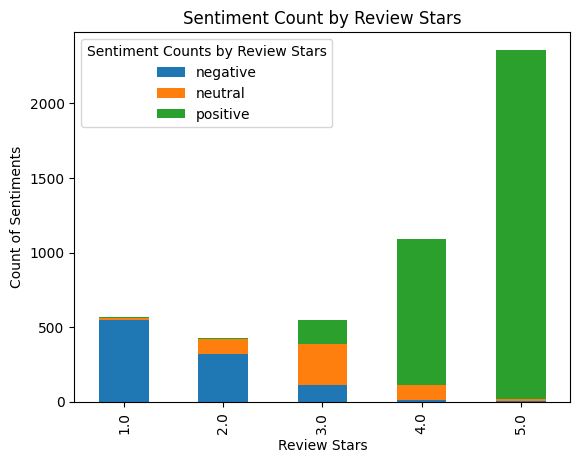

In [46]:
# Aggregate sentiments by review stars
sentiment_counts = test4.groupby(['review_stars', 'hf_sent_label']).size().reset_index(name='total_sentiment')

# Pivot the DataFrame for easier plotting
pivot_df = sentiment_counts.pivot(index='review_stars', columns='hf_sent_label', values='total_sentiment').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Count by Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment Counts by Review Stars')
plt.show()

This makes a lot of sense since most of the negative sentiment/blue color are in lower ratings and most of the positive sentiment/positive color are in higher ratings with neutral/orange concentrated in center of visualization: rating 3.

In [47]:
# Look at the box plot of sentiment ratios broken down by overall sentiment
# Plot boxplots for text_neg_ratio, text_neu_ratio, and text_pos_ratio broken down by hf_sent_label

# plt.figure(figsize=(15, 5))

# # Plot for text_neg_ratio
# plt.subplot(1, 3, 1)
# sns.boxplot(x='hf_sent_label', y='text_neg_ratio', data=test4)
# plt.title('Boxplot of text_neg_ratio by Sentiment Label')

# # Plot for text_neu_ratio
# plt.subplot(1, 3, 2)
# sns.boxplot(x='hf_sent_label', y='text_neu_ratio', data=test4)
# plt.title('Boxplot of text_neu_ratio by Sentiment Label')

# # Plot for text_pos_ratio
# plt.subplot(1, 3, 3)
# sns.boxplot(x='hf_sent_label', y='text_pos_ratio', data=test4)
# plt.title('Boxplot of text_pos_ratio by Sentiment Label')

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()

High negative and high positive ratios correspond with neg/pos sentiments. Review sentiment composition gets murky with neutral sentiment since a neutral stance with a restaurant can have a bunch of negative or neutral comments. Would need to look at star rating to get a better view of what sentiment is majority in neutral classified reviews. Let's take a quick peek.

In [48]:
# query = """
# select review_stars
# , clean_text
# , hf_sent_label
# -- , text_neu_ratio
# -- , text_neg_ratio
# -- , text_pos_ratio
# from test4
# where hf_sent_label = 'neutral'
# """

# neutral = duckdb.query(query).df()
# neutral.head(10)

Text mostly is comprised of what:

0. neutral then little neg; neutral ratio correct
1. neg; wrong neg ratio
2. pos and neg (60%); wrong ratio for pos
3. pos, neutral, neg; wrong ratio for pos
4. pos, neg; pos was second
5. neg, pos; neg was low percent
6. neg, pos; neg is lowest ratio
7. pos and neg; pos is higher than neg but neu highest
8. neg, pos; pos has higher ratio than neg but neu highest
9. pos, neg; pos then neg but neu ratio is highest

Mapping review stars to sentiment is difficult because people have varying subjectve definitions for what deserves a 1 versus 5.

In [49]:
# dfr.head()

In [50]:
# Join sample table to dfr to get category and date for review

query = """
select *
from test4
inner join (select review_id as review_id, categories, date from dfr) as dfr
on test4.review_id = dfr.review_id
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,date
0,qLfBTKA-RO8wddFD1Ge8_Q,2.0,ate here for restaurant week. the atmosphere was great...the food not so much. we tried the calamari and meatballs for appetizers. they were both just okay. nothing special. something you could get at any chain restaurant. for meals we had two pasta dishes. the bucatini was basically a watered down alfredo. desserts also missed the mark. coffee cake and chocolate cake. we didn't even eat it all. service was slow but i'll give a pass since they were packed for restaurant week. wouldn't recommend or go back.,neutral,0.543425,qLfBTKA-RO8wddFD1Ge8_Q,"Bars, Restaurants, Nightlife, Italian",2019-09-14 12:32:01
1,6vjigIZ1yrVyNW36SIzKPA,1.0,"this was my second time visiting giordano's and first time at this indy location. we didn't want to wait for a table so we sat down at the bar to eat. we made friends with some fellow diners and waited... waited... and waited. the bar was full when we arrived, but cleared out soon after sitting. the server finally noticed we were sitting at the bar and unenthusiastically asked if we wanted menus. several minutes later we received water and several minutes after that we finally ordered. an hour later, we received our two 6"" deep dish pizzas... to go. while waiting, i noticed that the server seemed distracted by the computer, filled her own drink (while ours remained empty), heard several explicative words from our server, heard our server say she doesn't want to serve one more table, heard server cursing while interacting with other diners, saw staff just standing around and several other diners trying to practice patience. pizza is good, but won't be returning to this location. my wife and i were really disappointed.",negative,0.974253,6vjigIZ1yrVyNW36SIzKPA,"Restaurants, Pizza, Italian, Salad",2016-11-05 03:06:22
2,OjkLWNOaCaIUOx-Pn-YvXQ,3.0,the quality of the fish wasnt too good but the plating and ambiance was nice. this is byob and they do provide you with glasses and ice bucket. sushi dinner was just okay but i really liked the ginger dressing on the salad that came with the entree. the seafood udon soup was disappointing because all the seafood looked old and bad. i didnt wanna risk getting sick. they also do charge you for side of sauces.,neutral,0.897429,OjkLWNOaCaIUOx-Pn-YvXQ,"Japanese, Asian Fusion, Seafood, Restaurants, Sushi Bars",2016-03-15 06:55:23
3,MfoHsH8JwBjMRTWFD2UtDA,5.0,"this is a little mom and pop place. we've always gotten the food to go, but there are little tables you can eat at. the beans here are amazing!! weve had a variety of things, from the tacos to the enchiladas. all have them have been amazing. this isnt a glamorous place, but if you want good mexican food this is the place!!",positive,0.996722,MfoHsH8JwBjMRTWFD2UtDA,"Restaurants, Mexican",2020-04-26 16:35:47
4,XHkxm1hLFv0-83xsFswVFg,5.0,great spot for brunch! the host cole was very nice and helped our party right away during the busy brunch rush! would highly recommend,positive,0.997920,XHkxm1hLFv0-83xsFswVFg,"Wine Bars, Desserts, Bars, American (New), Nightlife, Restaurants, Italian, Food, Salad, Breakfast & Brunch, Pizza",2018-12-09 18:04:37
5,BFb-hW7p5_irAyg-Lwo8Gg,3.0,okay for midwest pizza but way overpriced (imho). either you can get deep dish or a thin crust (no ny style apparently). sauce is tasty and toppings are good but expensive if building your own pizza. service was poor. my drink went about 15 minutes from empty glass to refill which is unacceptable. not good enough pizza to justify obama spending millions of tax money to have it delivered to the white house. i'm sure dc has a couple of joints on par with (if not better than) this place.,negative,0.788149,BFb-hW7p5_irAyg-Lwo8Gg,"Nightlife, Pizza, Bars, Restaurants",2010-11-15 04:39:11
6,DlLlZkLf8xvJbqwH-Sx84w,3.0,"so i've been here a few times now and i'm not quite sure what the hype is for the corn bread crust. in theory it sou

In [51]:
# top categories mentioned in reviews
# test5['categories'].value_counts()

In [52]:
# Sentiment breakdown for category; only work with top 5
query = """
select *
from test5
where categories in ('Restaurants, Mexican', 'Restaurants, Pizza', 'Restaurants, Chinese', 'Restaurants, Italian', 'Restaurants, Seafood')
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,date
0,MfoHsH8JwBjMRTWFD2UtDA,5.0,"this is a little mom and pop place. we've always gotten the food to go, but there are little tables you can eat at. the beans here are amazing!! weve had a variety of things, from the tacos to the enchiladas. all have them have been amazing. this isnt a glamorous place, but if you want good mexican food this is the place!!",positive,0.996722,MfoHsH8JwBjMRTWFD2UtDA,"Restaurants, Mexican",2020-04-26 16:35:47
1,3RAEejLnIg98FU_dR2nn8Q,1.0,"rude people. called to order a custom pizza, been asked to read the pre-assembled options in the menu and call back. do not feel like calling back.",negative,0.990450,3RAEejLnIg98FU_dR2nn8Q,"Restaurants, Pizza",2019-07-29 18:37:04
2,mWu_tiimqMQ1OxhuqmLQ_g,5.0,"always great food and drinks here. wife and i had the halibut special last night and it was amazing. sherry the bartender is the best. it's a must stopped if you are in the swedesboro area, authentic italian is hard to find but this place just kills it with flavor and portion sizes are huge.",positive,0.995981,mWu_tiimqMQ1OxhuqmLQ_g,"Restaurants, Italian",2017-07-07 15:09:40
3,RJdGzupSbBa9sloVXReKvw,5.0,best spot for posole!!! very generous portions! homemade tortillas! everything is delicious! you won't leave here hungry or disappointed!,positive,0.998299,RJdGzupSbBa9sloVXReKvw,"Restaurants, Mexican",2020-10-17 14:54:16
4,6fbEw78bkVJRovy_FPYmoQ,4.0,"seafood was good and fresh had 2 pounds of shrimp with potatoes and corn about 26.00 appetizer fried crab claws, clams stuffed mushrooms and onion rings about 15.00 , kids popcorn shrimp, oh and the abita beer only 2.00 for draft not bad at all.. good overall seafood, and close to our hotel",positive,0.904710,6fbEw78bkVJRovy_FPYmoQ,"Restaurants, Seafood",2019-07-21 20:15:39
5,uLlfvZ7c8KBQK31P1PK17A,5.0,"if you want wonderful, real mexican this is the place to go! i spent time living in southern az and went to mexico often to hit taco shops. i thought i would not find the true bliss of a real taco again, but this place nails it! there are a few tables to sit and eat, but i would imagine most of the business is take out. not that i would not order some great food, pull up a table and enjoy the tacos with a few cold ones to wash them down.",positive,0.992057,uLlfvZ7c8KBQK31P1PK17A,"Restaurants, Mexican",2016-03-05 20:47:12
6,2b17EByEQyIBFgds3e1Mzg,5.0,"i ordered uber eats from wolf street today for my sons 5th birthday. the uber delivery person left behind an entire pizza. without hesitation, the restaurant offered to have one of their own drivers deliver the pie. it took maybe ten minutes. and they did this to rectify an error that wasn't even their fault. classy joint and they have my loyalty! thank you!!",positive,0.951225,2b17EByEQyIBFgds3e1Mzg,"Restaurants, Pizza",2020-12-06 20:05:29
7,cD-BgWjVTwUoDrkBnfhJ-g,5.0,of all the places where you can get a seafood boil in indy this is the best one. this place also doesn't skimp on serving size you get what you pay for and then some. the seafood is fresh and when you order spicy it is actually spicy. we ordered the super platter and it was honestly way too much food for us but so delicious.,positive,0.995666,cD-BgWjVTwUoDrkBnfhJ-g,"Restaurants, Seafood",2019-03-31 00:25:38
8,hFePzZIqXlskd7qFpqGdvQ,3.0,this place is really nice over all the staff is friendly and so are the owners . the only problem is is that the fries are so thin along with the pizza they aren't really that good .,neutral,0.853053,hFePzZIqXlskd7qFpqGdvQ,"Restaurants, Pizza",2019-02-14 03:45:01
9,KhjQz4chC56pGq49mEehuQ,5.0,i still totally love little china town after the very important 3rd visit. but let me address a false review real quick. someone said they charge a huge automatic tip. that is a lie. this is most likely an ex-employee or something. never had anything but professional treatment and good food. and i'm a total hard-ass about my reviews and i still l

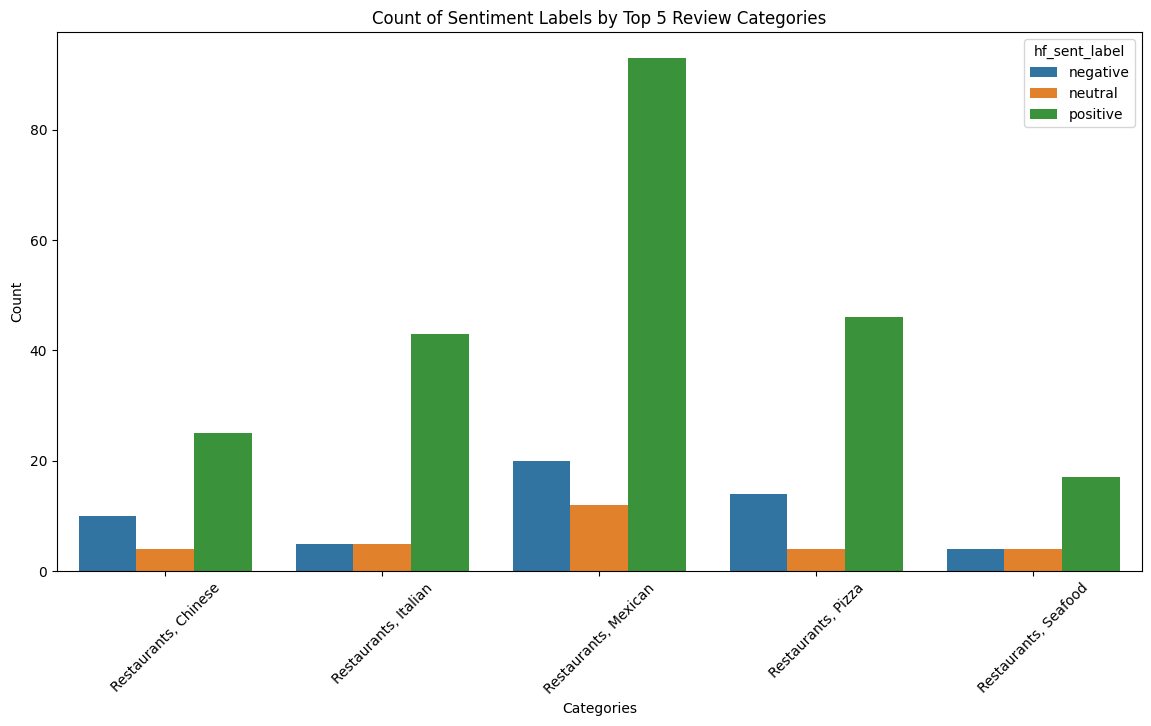

In [53]:
# Group by hf_sent_label and categories and count occurrences
df_grouped = test5.groupby(['hf_sent_label', 'categories']).size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x='categories', y='count', hue='hf_sent_label', data=df_grouped)
plt.xticks(rotation=45)
plt.title('Count of Sentiment Labels by Top 5 Review Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

For Mexican Restaurants, positive reviews far outweigh any other cateory.

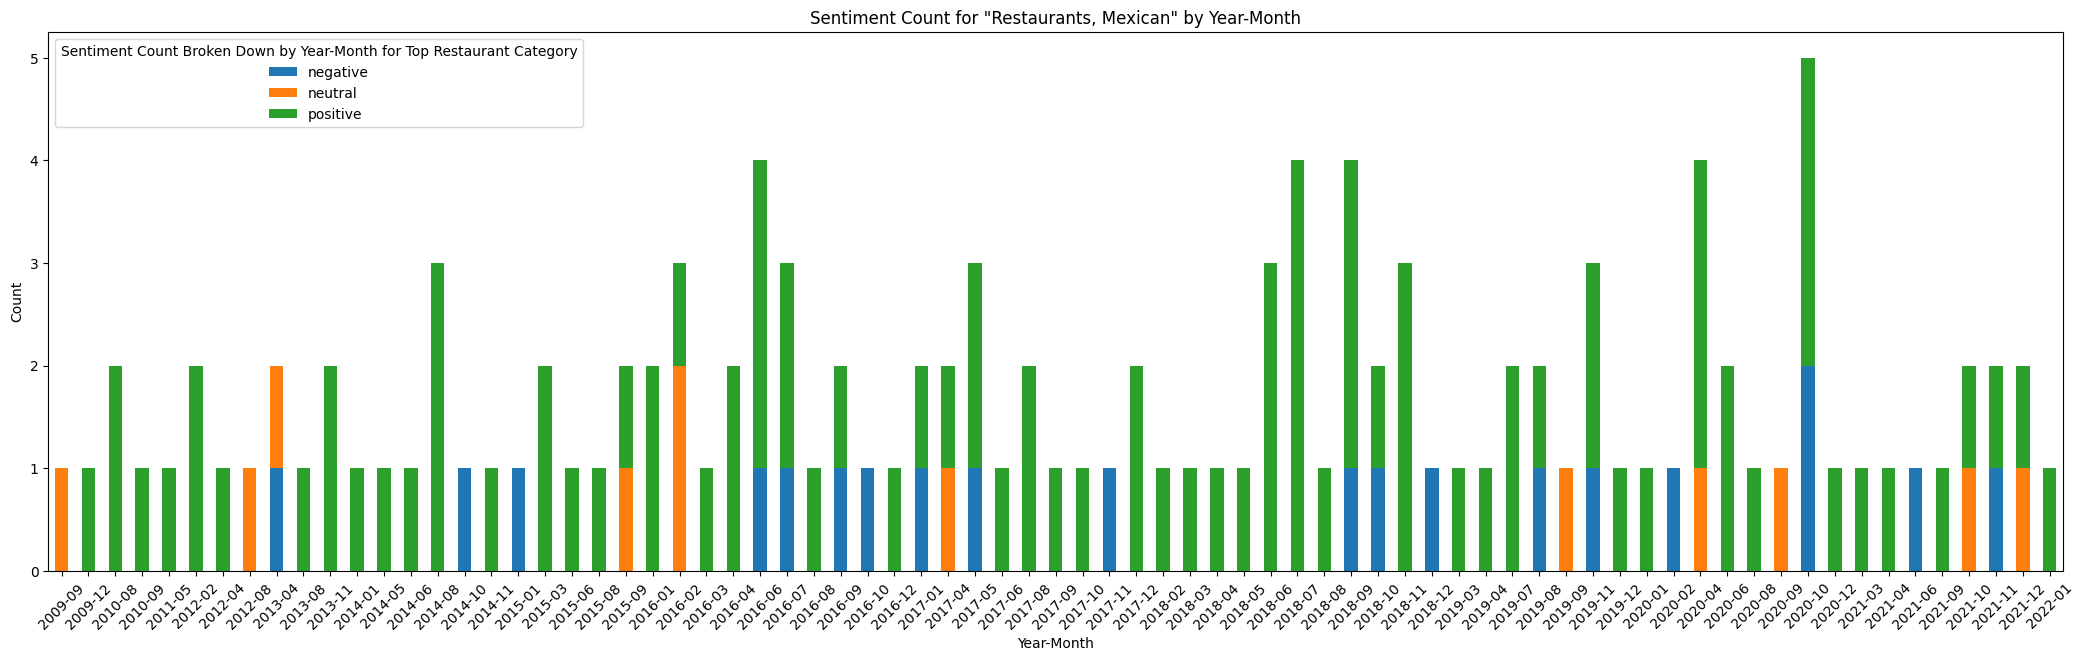

In [54]:
# Sentiment over time for top category: Restaurants, Mexican
# Filter the DataFrame to include only rows where categories is 'Restaurants, Mexican'
df_filtered = test5[test5['categories'] == 'Restaurants, Mexican']

# Convert the date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract year and month from the date column
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# Group by hf_sent_label and year_month and count occurrences
df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
plt.show()

Mexican Restaurant category did best in 2018 spring. Would be interesting to focus in on one particular business and see sentiment trend over time.

And of course we want to know what are the reasons for certain sentiments. 
First, let's look at the most talked about topics in these restaurnt reviews.

# Topic Modeling


Extensive pre-processing need to be done because topic modeling cannot interpret all the text noise as well as Hugging Face LLM's can.

In [55]:
test6 = df_filtered.copy()

In [56]:
# Expand contractions and translate common social acronyms

# Dictionary for contractions
contractions_dict = {
    "i've": "I have",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "I am",
    "you're": "you are",
    "you've": "you have",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "you'd": "you would",
    "they'd": "they would",
    "we'd": "we would",
    "she'd": "she would",
    "he'd": "he would",
    "i'd": "I would",
    "it'd": "it would",
    "who'd": "who would",
    "what's": "what is",
    "how's": "how is",
    "let's": "let us",
    "here's": "here is"
}

# Dictionary for social acronyms
acronyms_dict = {
    "lol": "laugh out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I do not know",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "fyi": "for your information",
    "lmk": "let me know",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the heck",
    "wth": "what the heck",
    "xoxo": "hugs and kisses"
}

# Combine both dictionaries
combined_dict = {**contractions_dict, **acronyms_dict}

# Function to expand contractions and acronyms
def expand_text(text):
    def replace(match):
        return combined_dict[match.group(0).lower()]

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in combined_dict.keys()) + r')\b', re.IGNORECASE)
    expanded_text = pattern.sub(replace, text)
    return expanded_text

# Example usage
# text = "I've been busy lol. IDK what's happening, but can't wait to see you!"
# expanded_text = expand_text(text)
# print(expanded_text)

In [57]:
# given context of reviews, need to translate $ and % amounts into english

# def translate_amounts(text):
#     # Define regex patterns for dollar amounts and percentages
#     dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
#     percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

#     # Replace dollar amounts with "X dollars"
#     text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
#     # Replace percentages with "X percent"
#     text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
#     return text

# Example usage
# text = "The price is $4.00 and the discount is 4%."
# translated_text = translate_amounts(text)
# print(translated_text)  # Output: The price is 4.0 dollars and the discount is 4.0 percent.

In [58]:
# def replace_ampersand(text):
#     return text.replace('&', 'and')

# sentence = 'This is a test for &'
# print(replace_ampersand(sentence))

In [59]:
# def remove_punctuation(text):
#     return re.sub(r'[^\w\s]', '', text)

In [60]:
def more_txt_prep(text):
    # Define regex patterns for dollar amounts and percentages
    dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
    percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

    # Replace dollar amounts with "X dollars"
    text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
    # Replace percentages with "X percent"
    text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
    #replace ampersand
    text = text.replace('&', 'and')
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [61]:
# Some More Text Pre-Processing: tokenize, lemmatize, remove stop words

test6['clean_text2'] = test6.apply(lambda row: expand_text(row.clean_text), axis = 1)
test6['clean_text2'] = test6.apply(lambda row: more_txt_prep(row.clean_text2), axis = 1)
test6['tokenized'] = test6.apply(lambda row: tokenizer.tokenize(row.clean_text2), axis = 1)
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,date,year_month,clean_text2,tokenized
0,MfoHsH8JwBjMRTWFD2UtDA,5.0,"this is a little mom and pop place. we've always gotten the food to go, but there are little tables you can eat at. the beans here are amazing!! weve had a variety of things, from the tacos to the enchiladas. all have them have been amazing. this isnt a glamorous place, but if you want good mexican food this is the place!!",positive,0.996722,MfoHsH8JwBjMRTWFD2UtDA,"Restaurants, Mexican",2020-04-26 16:35:47,2020-04,this is a little mom and pop place weve always gotten the food to go but there are little tables you can eat at the beans here are amazing weve had a variety of things from the tacos to the enchiladas all have them have been amazing this isnt a glamorous place but if you want good mexican food this is the place,"[this, is, a, little, mom, and, pop, place, we, ##ve, always, gotten, the, food, to, go, but, there, are, little, tables, you, can, eat, at, the, beans, here, are, amazing, we, ##ve, had, a, variety, of, things, from, the, ta, ##cos, to, the, en, ##chi, ##lad, ##as, all, have, them, have, been, amazing, this, isn, ##t, a, g, ##lam, ##orous, place, but, if, you, want, good, mexican, food, this, is, the, place]"
3,RJdGzupSbBa9sloVXReKvw,5.0,best spot for posole!!! very generous portions! homemade tortillas! everything is delicious! you won't leave here hungry or disappointed!,positive,0.998299,RJdGzupSbBa9sloVXReKvw,"Restaurants, Mexican",2020-10-17 14:54:16,2020-10,best spot for posole very generous portions homemade tortillas everything is delicious you will not leave here hungry or disappointed,"[best, spot, for, po, ##sol, ##e, very, generous, portions, homemade, tor, ##till, ##as, everything, is, delicious, you, will, not, leave, here, hungry, or, disappointed]"
5,uLlfvZ7c8KBQK31P1PK17A,5.0,"if you want wonderful, real mexican this is the place to go! i spent time living in southern az and went to mexico often to hit taco shops. i thought i would not find the true bliss of a real taco again, but this place nails it! there are a few tables to sit and eat, but i would imagine most of the business is take out. not that i would not order some great food, pull up a table and enjoy the tacos with a few cold ones to wash them down.",positive,0.992057,uLlfvZ7c8KBQK31P1PK17A,"Restaurants, Mexican",2016-03-05 20:47:12,2016-03,if you want wonderful real mexican this is the place to go i spent time living in southern az and went to mexico often to hit taco shops i thought i would not find the true bliss of a real taco again but this place nails it there are a few tables to sit and eat but i would imagine most of the business is take out not that i would not order some great food pull up a table and enjoy the tacos with a few cold ones to wash them down,"[if, you, want, wonderful, real, mexican, this, is, the, place, to, go, i, spent, time, living, in, southern, az, and, went, to, mexico, often, to, hit, ta, ##co, shops, i, thought, i, would, not, find, the, true, bliss, of, a, real, ta, ##co, again, but, this, place, nails, it, there, are, a, few, tables, to, sit, and, eat, but, i, would, imagine, most, of, the, business, is, take, out, not, that, i, would, not, order, some, great, food, pull, up, a, table, and, enjoy, the, ta, ##cos, with, a, few, cold, ones, to, wash, them, down]"
11,I_W3fTO6Y2Z2439gcXjM2A,2.0,"low expectationswere met by dollar tacossave it for homeless if there is any word to describe this place it is ""underwhelmed"". i mean, they have $1 tacos, and a decent happy hour. but i can make it better on my own. other than that, the decor is bright, the service was fast, the table smelled overly clean. lame-o mexican food. i won't be returning.",negative,0.973854,I_W3fTO6Y2Z2439gcXjM2A,"Restaurants, Mexican",2014-10-09 13:02:41,2014-10,low expectationswere met by dollar tacossave it for homeless if there is any word to describe this place it is underwh

In [62]:
# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stop words from the 'tokens' column
test6['tokens_no_stopwords'] = test6['tokenized'].apply(remove_stopwords)

test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords
0,MfoHsH8JwBjMRTWFD2UtDA,5.0,"this is a little mom and pop place. we've always gotten the food to go, but there are little tables you can eat at. the beans here are amazing!! weve had a variety of things, from the tacos to the enchiladas. all have them have been amazing. this isnt a glamorous place, but if you want good mexican food this is the place!!",positive,0.996722,MfoHsH8JwBjMRTWFD2UtDA,"Restaurants, Mexican",2020-04-26 16:35:47,2020-04,this is a little mom and pop place weve always gotten the food to go but there are little tables you can eat at the beans here are amazing weve had a variety of things from the tacos to the enchiladas all have them have been amazing this isnt a glamorous place but if you want good mexican food this is the place,"[this, is, a, little, mom, and, pop, place, we, ##ve, always, gotten, the, food, to, go, but, there, are, little, tables, you, can, eat, at, the, beans, here, are, amazing, we, ##ve, had, a, variety, of, things, from, the, ta, ##cos, to, the, en, ##chi, ##lad, ##as, all, have, them, have, been, amazing, this, isn, ##t, a, g, ##lam, ##orous, place, but, if, you, want, good, mexican, food, this, is, the, place]","[little, mom, pop, place, ##ve, always, gotten, food, go, little, tables, eat, beans, amazing, ##ve, variety, things, ta, ##cos, en, ##chi, ##lad, ##as, amazing, ##t, g, ##lam, ##orous, place, want, good, mexican, food, place]"
3,RJdGzupSbBa9sloVXReKvw,5.0,best spot for posole!!! very generous portions! homemade tortillas! everything is delicious! you won't leave here hungry or disappointed!,positive,0.998299,RJdGzupSbBa9sloVXReKvw,"Restaurants, Mexican",2020-10-17 14:54:16,2020-10,best spot for posole very generous portions homemade tortillas everything is delicious you will not leave here hungry or disappointed,"[best, spot, for, po, ##sol, ##e, very, generous, portions, homemade, tor, ##till, ##as, everything, is, delicious, you, will, not, leave, here, hungry, or, disappointed]","[best, spot, po, ##sol, ##e, generous, portions, homemade, tor, ##till, ##as, everything, delicious, leave, hungry, disappointed]"
5,uLlfvZ7c8KBQK31P1PK17A,5.0,"if you want wonderful, real mexican this is the place to go! i spent time living in southern az and went to mexico often to hit taco shops. i thought i would not find the true bliss of a real taco again, but this place nails it! there are a few tables to sit and eat, but i would imagine most of the business is take out. not that i would not order some great food, pull up a table and enjoy the tacos with a few cold ones to wash them down.",positive,0.992057,uLlfvZ7c8KBQK31P1PK17A,"Restaurants, Mexican",2016-03-05 20:47:12,2016-03,if you want wonderful real mexican this is the place to go i spent time living in southern az and went to mexico often to hit taco shops i thought i would not find the true bliss of a real taco again but this place nails it there are a few tables to sit and eat but i would imagine most of the business is take out not that i would not order some great food pull up a table and enjoy the tacos with a few cold ones to wash them down,"[if, you, want, wonderful, real, mexican, this, is, the, place, to, go, i, spent, time, living, in, southern, az, and, went, to, mexico, often, to, hit, ta, ##co, shops, i, thought, i, would, not, find, the, true, bliss, of, a, real, ta, ##co, again, but, this, place, nails, it, there, are, a, few, tables, to, sit, and, eat, but, i, would, imagine, most, of, the, business, is, take, out, not, that, i, would, not, order, some, great, food, pull, up, a, table, and, enjoy, the, ta, ##cos, with, a, few, cold, ones, to, wash, them, down]","[want, wonderful, real, mexican, place, go, spent, time, living, southern, az, went, mexico, often, hit, ta, ##co, shops, thought, would, find, true, bliss, real, ta, ##co, place, nails, tables, sit, eat, would, i

In [63]:
# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Apply the lemmatization function to the 'tokens' column
test6['lemmatized_tokens'] = test6['tokens_no_stopwords'].apply(lemmatize_tokens)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens
0,MfoHsH8JwBjMRTWFD2UtDA,5.0,"this is a little mom and pop place. we've always gotten the food to go, but there are little tables you can eat at. the beans here are amazing!! weve had a variety of things, from the tacos to the enchiladas. all have them have been amazing. this isnt a glamorous place, but if you want good mexican food this is the place!!",positive,0.996722,MfoHsH8JwBjMRTWFD2UtDA,"Restaurants, Mexican",2020-04-26 16:35:47,2020-04,this is a little mom and pop place weve always gotten the food to go but there are little tables you can eat at the beans here are amazing weve had a variety of things from the tacos to the enchiladas all have them have been amazing this isnt a glamorous place but if you want good mexican food this is the place,"[this, is, a, little, mom, and, pop, place, we, ##ve, always, gotten, the, food, to, go, but, there, are, little, tables, you, can, eat, at, the, beans, here, are, amazing, we, ##ve, had, a, variety, of, things, from, the, ta, ##cos, to, the, en, ##chi, ##lad, ##as, all, have, them, have, been, amazing, this, isn, ##t, a, g, ##lam, ##orous, place, but, if, you, want, good, mexican, food, this, is, the, place]","[little, mom, pop, place, ##ve, always, gotten, food, go, little, tables, eat, beans, amazing, ##ve, variety, things, ta, ##cos, en, ##chi, ##lad, ##as, amazing, ##t, g, ##lam, ##orous, place, want, good, mexican, food, place]","[little, mom, pop, place, #, #, ve, always, get, food, go, little, table, eat, bean, amazing, #, #, ve, variety, thing, ta, #, #, cos, en, #, #, chi, #, #, lad, #, #, as, amazing, #, #, t, g, #, #, lam, #, #, orous, place, want, good, mexican, food, place]"
3,RJdGzupSbBa9sloVXReKvw,5.0,best spot for posole!!! very generous portions! homemade tortillas! everything is delicious! you won't leave here hungry or disappointed!,positive,0.998299,RJdGzupSbBa9sloVXReKvw,"Restaurants, Mexican",2020-10-17 14:54:16,2020-10,best spot for posole very generous portions homemade tortillas everything is delicious you will not leave here hungry or disappointed,"[best, spot, for, po, ##sol, ##e, very, generous, portions, homemade, tor, ##till, ##as, everything, is, delicious, you, will, not, leave, here, hungry, or, disappointed]","[best, spot, po, ##sol, ##e, generous, portions, homemade, tor, ##till, ##as, everything, delicious, leave, hungry, disappointed]","[good, spot, po, #, #, sol, #, #, e, generous, portion, homemade, tor, #, #, till, #, #, as, everything, delicious, leave, hungry, disappoint]"
5,uLlfvZ7c8KBQK31P1PK17A,5.0,"if you want wonderful, real mexican this is the place to go! i spent time living in southern az and went to mexico often to hit taco shops. i thought i would not find the true bliss of a real taco again, but this place nails it! there are a few tables to sit and eat, but i would imagine most of the business is take out. not that i would not order some great food, pull up a table and enjoy the tacos with a few cold ones to wash them down.",positive,0.992057,uLlfvZ7c8KBQK31P1PK17A,"Restaurants, Mexican",2016-03-05 20:47:12,2016-03,if you want wonderful real mexican this is the place to go i spent time living in southern az and went to mexico often to hit taco shops i thought i would not find the true bliss of a real taco again but this place nails it there are a few tables to sit and eat but i would imagine most of the business is take out not that i would not order some great food pull up a table and enjoy the tacos with a few cold ones to wash them down,"[if, you, want, wonderful, real, mexican, this, is, the, place, to, go, i, spent, time, living, in, southern, az, and, went, to, mexico, often, to, hit, ta, ##co, shops, i, thought, i, would, not, find, the, true, bliss, of, a, real, ta, ##co, again, but, this, place, nails, it, there, are, a, few, tables, to, sit, and, eat, but, 

In [64]:
# turn cleaned up text column back to strings only

# Function to join list of strings into a single string
def list_to_string(list_of_strings):
    text = ' '.join(list_of_strings)
    return re.sub(r'[^\w\s]', '', text)  # remove punctuation again...

    
test6['clean_text3'] = test6['lemmatized_tokens'].apply(list_to_string)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens,clean_text3
0,MfoHsH8JwBjMRTWFD2UtDA,5.0,"this is a little mom and pop place. we've always gotten the food to go, but there are little tables you can eat at. the beans here are amazing!! weve had a variety of things, from the tacos to the enchiladas. all have them have been amazing. this isnt a glamorous place, but if you want good mexican food this is the place!!",positive,0.996722,MfoHsH8JwBjMRTWFD2UtDA,"Restaurants, Mexican",2020-04-26 16:35:47,2020-04,this is a little mom and pop place weve always gotten the food to go but there are little tables you can eat at the beans here are amazing weve had a variety of things from the tacos to the enchiladas all have them have been amazing this isnt a glamorous place but if you want good mexican food this is the place,"[this, is, a, little, mom, and, pop, place, we, ##ve, always, gotten, the, food, to, go, but, there, are, little, tables, you, can, eat, at, the, beans, here, are, amazing, we, ##ve, had, a, variety, of, things, from, the, ta, ##cos, to, the, en, ##chi, ##lad, ##as, all, have, them, have, been, amazing, this, isn, ##t, a, g, ##lam, ##orous, place, but, if, you, want, good, mexican, food, this, is, the, place]","[little, mom, pop, place, ##ve, always, gotten, food, go, little, tables, eat, beans, amazing, ##ve, variety, things, ta, ##cos, en, ##chi, ##lad, ##as, amazing, ##t, g, ##lam, ##orous, place, want, good, mexican, food, place]","[little, mom, pop, place, #, #, ve, always, get, food, go, little, table, eat, bean, amazing, #, #, ve, variety, thing, ta, #, #, cos, en, #, #, chi, #, #, lad, #, #, as, amazing, #, #, t, g, #, #, lam, #, #, orous, place, want, good, mexican, food, place]",little mom pop place ve always get food go little table eat bean amazing ve variety thing ta cos en chi lad as amazing t g lam orous place want good mexican food place
3,RJdGzupSbBa9sloVXReKvw,5.0,best spot for posole!!! very generous portions! homemade tortillas! everything is delicious! you won't leave here hungry or disappointed!,positive,0.998299,RJdGzupSbBa9sloVXReKvw,"Restaurants, Mexican",2020-10-17 14:54:16,2020-10,best spot for posole very generous portions homemade tortillas everything is delicious you will not leave here hungry or disappointed,"[best, spot, for, po, ##sol, ##e, very, generous, portions, homemade, tor, ##till, ##as, everything, is, delicious, you, will, not, leave, here, hungry, or, disappointed]","[best, spot, po, ##sol, ##e, generous, portions, homemade, tor, ##till, ##as, everything, delicious, leave, hungry, disappointed]","[good, spot, po, #, #, sol, #, #, e, generous, portion, homemade, tor, #, #, till, #, #, as, everything, delicious, leave, hungry, disappoint]",good spot po sol e generous portion homemade tor till as everything delicious leave hungry disappoint
5,uLlfvZ7c8KBQK31P1PK17A,5.0,"if you want wonderful, real mexican this is the place to go! i spent time living in southern az and went to mexico often to hit taco shops. i thought i would not find the true bliss of a real taco again, but this place nails it! there are a few tables to sit and eat, but i would imagine most of the business is take out. not that i would not order some great food, pull up a table and enjoy the tacos with a few cold ones to wash them down.",positive,0.992057,uLlfvZ7c8KBQK31P1PK17A,"Restaurants, Mexican",2016-03-05 20:47:12,2016-03,if you want wonderful real mexican this is the place to go i spent time living in southern az and went to mexico often to hit taco shops i thought i would not find the true bliss of a real taco again but this place nails it there are a few tables to sit and eat but i would imagine most of the business is take out not that i would not order some great food pull up a table and enjoy the tacos with a few cold ones to wash them down,"[if, you, want, wonderful, real, mexican, this, is

In [65]:
# Now trying topic modeling with cleaned text!
reindexed_data = test6['clean_text3']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + ['food', 'ta', 'take'], use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [66]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [67]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [68]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [69]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

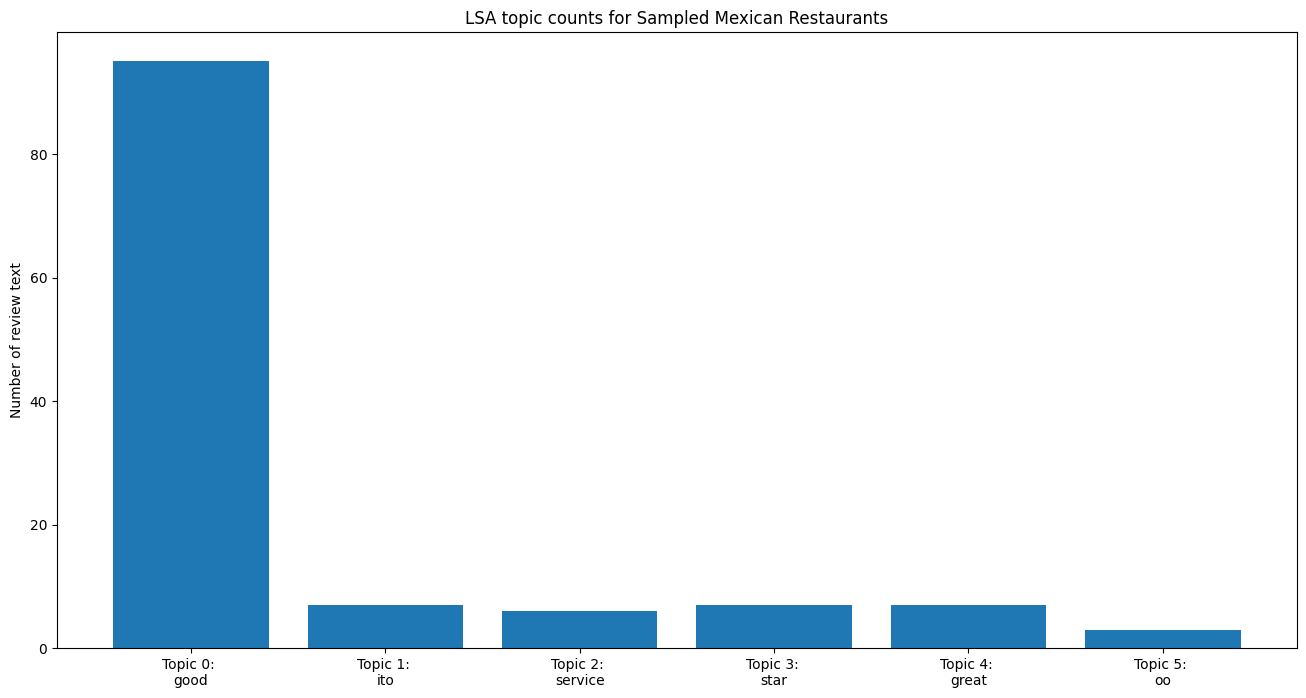

In [70]:
top_3_words = get_top_n_words(1, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts for Sampled Mexican Restaurants');
plt.show();

Not very good interpretation/extraction since Parts of Speech desired should be specified before doing topic modeling and text pre-processing made burrito burr...Trying another method.

In [71]:
# Download NLTK stopwords
nltk.download('stopwords')

# Sample Yelp reviews DataFrame
data = {
    'review': [
        "I love the tacos at this place. They're amazing!",
        "The service was terrible, I will not come back.",
        "Great atmosphere and friendly staff.",
        "The food was cold and tasteless.",
        "I enjoyed my time here, the music was good."
    ]
}
df = pd.DataFrame(data)

# Preprocess the reviews
stop_words = set(stopwords.words('english'))
df['processed'] = df['review'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# Create a dictionary and corpus
dictionary = corpora.Dictionary(df['processed'])
corpus = [dictionary.doc2bow(text) for text in df['processed']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(0, '0.133*"cold" + 0.133*"tasteless." + 0.133*"food" + 0.033*"staff." + 0.033*"friendly"')
(1, '0.063*"tacos" + 0.063*"place." + 0.063*"time" + 0.063*"love" + 0.063*"here,"')
(2, '0.121*"back." + 0.121*"come" + 0.121*"service" + 0.121*"terrible," + 0.030*"staff."')


1. Each line represets a different topic.
1. Topic can be inferred by given words, 5 total in this case.
1. Numbers next to words are probability that word would be chosen as topic in newly generated text.
1. These topics also cover adjectives. Need to do entity extraction to zoom-in on core review topics. For example, desired output would have been: food, service, ambiance.

Let's see what ouput is from applying this LDA model to Mexican restaurant reviews. 

In [72]:
test6['processed'] =test6['clean_text2'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# Create a dictionary and corpus
dictionary = corpora.Dictionary(test6['processed'])
corpus = [dictionary.doc2bow(text) for text in test6['processed']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.018*"food" + 0.015*"good" + 0.015*"mexican" + 0.009*"place" + 0.008*"always"')
(1, '0.013*"food" + 0.012*"place" + 0.010*"time" + 0.009*"good" + 0.008*"tacos"')
(2, '0.017*"food" + 0.013*"tacos" + 0.010*"great" + 0.010*"mexican" + 0.008*"service"')


Once again, best to get parts of speech/aspects from text and then model the topics. Ideally, would want an ouput that mentions food, service and atmosphere topics with adjetives describing each.

In [73]:
# list of tuples with each tuple having unique word in text and its freq

# # Function to clean and tokenize text
# def tokenize(text):
#     # Convert text to lower case
#     text = text.lower()
#     # Remove punctuation and split by whitespace
#     words = re.findall(r'\b\w+\b', text)
#     return words

# # Apply the tokenize function to the text column and create a Counter
# word_counter = Counter()
# test6['clean_text2'].apply(lambda x: word_counter.update(tokenize(x)))

# # Convert the Counter to a list of tuples (word, frequency)
# word_freq = list(word_counter.items())

# # Display the result
# print(word_freq)

References:
1. https://erickleppen.medium.com/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb
1. https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html

In [74]:
# Trying BERTopic

docs = test6['clean_text2']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-08 19:50:06,995 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-08 19:50:12,095 - BERTopic - Embedding - Completed ✓
2024-06-08 19:50:12,096 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-08 19:50:24,421 - BERTopic - Dimensionality - Completed ✓
2024-06-08 19:50:24,422 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-08 19:50:24,456 - BERTopic - Cluster - Completed ✓
2024-06-08 19:50:24,462 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-08 19:50:24,575 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,125,-1_mexican_tacos_ordered_salsa,"[mexican, tacos, ordered, salsa, burrito, rice, chips, restaurant, best, tortillas]","[small place with great food their portions r huge salsa they make is out of this world delicious fajitas and tacos 5 star food and 2 service none of servers speak english but they r friendly best mexican food around, the enchiladas potosinas are absolutely amazing a must try the rice and beans are really really good i really like the beans but sometimes i just need to add a touch more salt no big deal the mole they make is really good highly suggested chips come out nice and hot with some decent salsa and 2 side salsas to add heat i eat a lot of mexican and the food here is just different in a good way they make the tortillas when you order your food and play good music usually a footballsoccer match will be on i love this, still on the hunt for good mexican food since moving from the promise land texas we drove past las maracas and noticed that most of the people eating on the deck were hispanic always a good sign so we whipped the car around to give this place a try first off the chips and salsa were delicious we ordered off the lunch menu and the prices were so cheap the hubs ordered chicken enchiladas and i had food envy the queso sauce they put on top was to die for paired with their fresh and subtle mexican rice i wish i had ordered his dish i ordered the carne asada quesadilla tasty but it is hard to find an amazing cut of carne asada all in all this place was a nice escape best mexican food since moving from texas and might be our new local mexican restaurant]"


In [75]:
topic_model.get_topic(0)

False

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.
* Let's try another embedder.

In [76]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(test6['clean_text2'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
test6['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-06-08 19:51:04,774 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-08 19:51:07,529 - BERTopic - Dimensionality - Completed ✓
2024-06-08 19:51:07,532 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-08 19:51:07,541 - BERTopic - Cluster - Completed ✓
2024-06-08 19:51:07,546 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-08 19:51:07,657 - BERTopic - Representation - Completed ✓


CPU times: user 18.5 s, sys: 4.93 s, total: 23.4 s
Wall time: 42.8 s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,125,-1_mexican_tacos_ordered_salsa,"[mexican, tacos, ordered, salsa, burrito, rice, chips, restaurant, best, tortillas]","[small place with great food their portions r huge salsa they make is out of this world delicious fajitas and tacos 5 star food and 2 service none of servers speak english but they r friendly best mexican food around, the enchiladas potosinas are absolutely amazing a must try the rice and beans are really really good i really like the beans but sometimes i just need to add a touch more salt no big deal the mole they make is really good highly suggested chips come out nice and hot with some decent salsa and 2 side salsas to add heat i eat a lot of mexican and the food here is just different in a good way they make the tortillas when you order your food and play good music usually a footballsoccer match will be on i love this, still on the hunt for good mexican food since moving from the promise land texas we drove past las maracas and noticed that most of the people eating on the deck were hispanic always a good sign so we whipped the car around to give this place a try first off the chips and salsa were delicious we ordered off the lunch menu and the prices were so cheap the hubs ordered chicken enchiladas and i had food envy the queso sauce they put on top was to die for paired with their fresh and subtle mexican rice i wish i had ordered his dish i ordered the carne asada quesadilla tasty but it is hard to find an amazing cut of carne asada all in all this place was a nice escape best mexican food since moving from texas and might be our new local mexican restaurant]"


These different embeddings create topics that make more sense because selected words per topic have a theme:  service, food

### Trying Bigger dataset (with top 5 restaurants) to get more topics to avoid visualize_topics error

In [77]:
# %%time

# #load the universal sentence encoder model
# use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# #generate embeddings
# use4_embeddings = use4(test5['clean_text'])
# use= np.array(use4_embeddings)

# #create list from np arrays to store the embeddings in the dataframe
# test5['use4'] = use.tolist()

# #pass the embeddings into BERTopic
# topic_model.fit_transform(docs, use)

# #get topic info
# topic_model.get_topic_info()

In [78]:
# from hdbscan import HDBSCAN

# hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', prediction_data=True)
# topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs)

In [79]:
# Visualize topics
# topic_model.visualize_topics()

# Aspect Extraction: What is being talked about in the reviews? - Topics at a more granular level

# Aspect-based opinion mining

In [80]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("NUSTM/restaurant-t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("NUSTM/restaurant-t5-base")

# input_ids = tokenizer(
#    "The pizza here is delicious!!", return_tensors="pt"
# ).input_ids  # Batch size 1
# outputs = model(input_ids=input_ids)